In [3]:
#Imoporting packages
# ==============================================================================
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy import stats
import math

from sklearn import preprocessing as prp
from sklearn import model_selection as ms
from sklearn import linear_model as lm
from sklearn import svm
from sklearn import ensemble
from sklearn import tree
from sklearn import metrics
from sklearn import dummy
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
#import sklearn.pipeline as pipeline 

from lazypredict.Supervised import LazyClassifier

# Pandas Configuration
# ==============================================================================
pd.set_option('float_format', '{:.3f}'.format) # float numbers with 2 decimals
pd.set_option("display.max_columns", None) # Display all columns

# Seaborn configuration
# ==============================================================================
sns.set_theme(style='darkgrid', palette='deep')
dims = (20, 16)

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)



## Nivell 2

- ### **Exercici 5**

Realitza algun procés d’enginyeria de variables per millorar-ne la predicció

## **Loading The Dataset with the sample**

In [4]:
flights_mod = pd.read_csv('../db/Flights/Flights_Sample.csv', index_col=0)

## **Analizing the relations within the attributes to descart the ones that don't bring information**

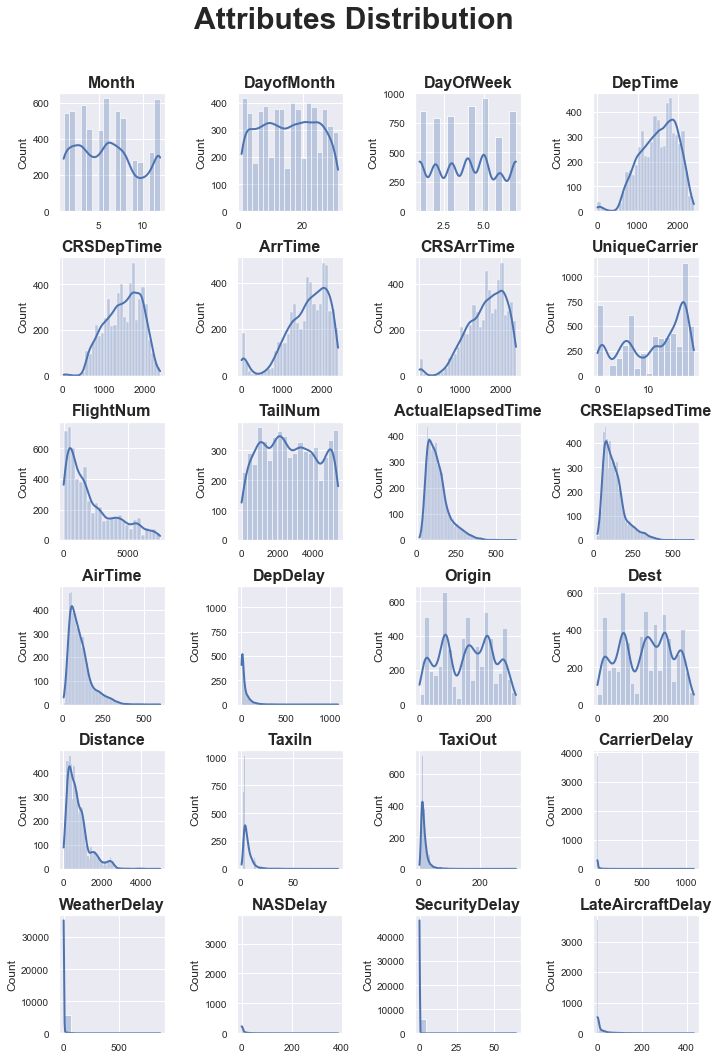

In [5]:
# Distribution graph for each attribute
# ==============================================================================

graphs = flights_mod.copy().drop(axis=1, columns=['ArrDelay'])
fig, axes = plt.subplots(ncols=4, nrows=6, figsize=(10, 15))
axes = axes.flat
for i, colum in enumerate(graphs):
    sns.histplot( data=graphs,x= colum, stat="count",kde= True, line_kws={'linewidth': 2},alpha= 0.3,ax= axes[i])
    axes[i].set_title(colum, fontsize = 16, fontweight = "bold")
    axes[i].tick_params(labelsize = 10)
    axes[i].set_xlabel("")
    
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Attributes Distribution', fontsize = 30, fontweight = "bold")
plt.show()

del graphs

## **Correlation with Target**

In [6]:
# Making a correlation matrix
# ==============================================================================
flights_corr = flights_mod.corr(method='pearson')

# Correlation with the target attribute
# ==============================================================================
corr_with_target = flights_corr['ArrDelay'].sort_values(ascending=False)
corr_with_target


ArrDelay             1.000
DepDelay             0.362
LateAircraftDelay    0.282
TaxiOut              0.219
CarrierDelay         0.219
NASDelay             0.218
DepTime              0.129
TaxiIn               0.117
FlightNum            0.086
CRSDepTime           0.079
WeatherDelay         0.072
CRSArrTime           0.072
ArrTime              0.047
SecurityDelay        0.029
TailNum              0.021
ActualElapsedTime    0.011
DayofMonth           0.001
DayOfWeek           -0.006
Dest                -0.012
Month               -0.027
Origin              -0.037
AirTime             -0.042
UniqueCarrier       -0.053
CRSElapsedTime      -0.074
Distance            -0.082
Name: ArrDelay, dtype: float64

The table above shows the correlation between the target attribute and each input variable. It can be observed there is some attributes that hava a very strong or vey weak correlation between those attributes and the target. 
A weak correlation means that the attribute has a little or none influence on the Target while a very high correlation could mean that the input attribute is strongly dependent or analogue to the Target. In both cases this attributes can be deletted to achie a better performance and avoid overfitting.

In [7]:
# Selecting the independent attributes poorly related to the target
# ==============================================================================
low_corr_att = corr_with_target[(corr_with_target <=0.05)&(corr_with_target>=-0.05)]
low_corr_att

ArrTime              0.047
SecurityDelay        0.029
TailNum              0.021
ActualElapsedTime    0.011
DayofMonth           0.001
DayOfWeek           -0.006
Dest                -0.012
Month               -0.027
Origin              -0.037
AirTime             -0.042
Name: ArrDelay, dtype: float64

## **Correlation within the Attributes**

Text(0.5, 0.98, 'Correlation Matrix')

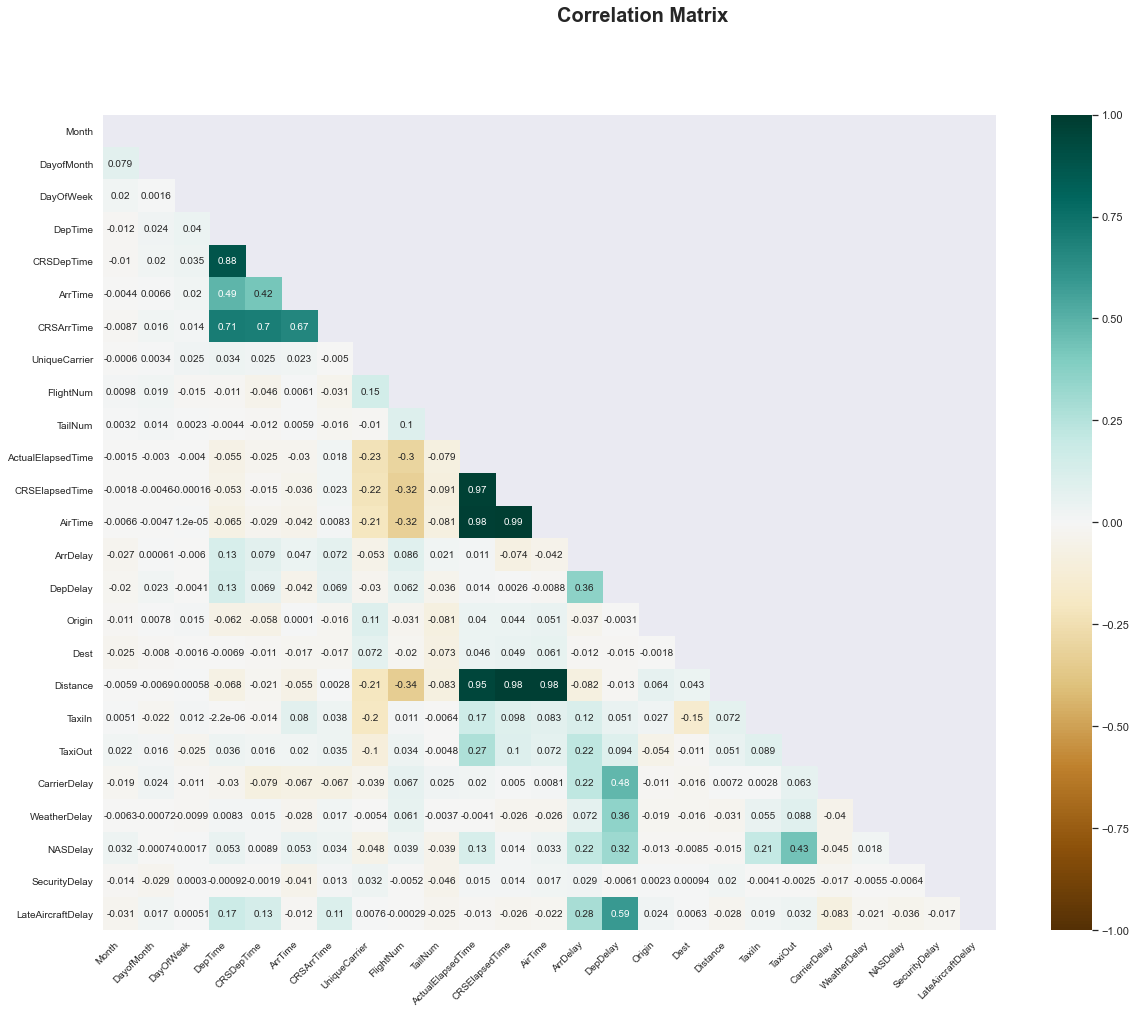

In [8]:
# Heatmap matrix of correlations
# ==============================================================================

# Getting the Upper Triangle of the co-relation matrix
mask_matrix = np.triu(flights_corr, k=0) # This will be applied as a mask

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 15))
sns.heatmap(flights_corr, annot=True, mask=mask_matrix, cmap="BrBG", vmin=-1, vmax=1, annot_kws = {"size": 10})
# Setting the plotting parameters
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, horizontalalignment = 'right')
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, horizontalalignment = 'right')
ax.tick_params(labelsize = 10)
fig.suptitle('Correlation Matrix', fontsize = 20, fontweight = "bold")

In [9]:
# Getting the Hihg correlated Attributes
# =====================================================
high_corr = flights_corr[(flights_corr >= 0.8) | (flights_corr<=-0.8)] 
high_corr[(high_corr<1)].stack()

DepTime            CRSDepTime          0.881
CRSDepTime         DepTime             0.881
ActualElapsedTime  CRSElapsedTime      0.970
                   AirTime             0.977
                   Distance            0.952
CRSElapsedTime     ActualElapsedTime   0.970
                   AirTime             0.985
                   Distance            0.982
AirTime            ActualElapsedTime   0.977
                   CRSElapsedTime      0.985
                   Distance            0.980
Distance           ActualElapsedTime   0.952
                   CRSElapsedTime      0.982
                   AirTime             0.980
dtype: float64

Highly correlated Attributes must be deleted in order improve the perfomance and Runtime of the algorithms. 
At this point. "CRS" Attributes will prevail over "Actual Time" Attributes as thei are te ones that can be know before a flight, hence more useful to predict if the flight will be late.

In [10]:
high_corr_drop = ["ActualElapsedTime", "AirTime", "Distance","DepTime"]

# Dropping Selected Attributes (Hig + Low Correlation)
# ==================================================================
attributes_drop = set(list(low_corr_att.index) + list(high_corr_drop))
flights_mod = flights_mod.drop(columns=attributes_drop)
flights_mod

,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,CRSElapsedTime,ArrDelay,DepDelay,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,LateAircraftDelay
1251307,1115,1215,17.000,1091.000,60,0,9,5,7,0,0,0,0
4750566,1130,1520,1.000,1685.000,170,1,22,7,23,22,0,13,0
6773048,1210,1355,7.000,5607.000,105,0,16,7,13,0,0,0,0
58354,1950,2045,17.000,1270.000,115,1,56,4,25,7,0,17,49
6648930,1709,1937,14.000,6168.000,88,1,50,3,13,0,0,0,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6720291,901,1221,16.000,1830.000,140,1,7,5,18,0,0,0,0
2348405,1725,2211,5.000,1136.000,226,1,22,11,35,0,0,16,0
1468317,2010,2133,16.000,1912.000,83,0,18,5,9,0,0,0,0
6875026,700,955,0.000,2178.000,175,1,19,4,14,0,0,0,0


## **Scaling Attributes**

In [11]:
# Splitting the Dataframe into dependent and independent attributes
# ==========================================================================
X = flights_mod.drop('ArrDelay', axis=1)
y = flights_mod['ArrDelay']

In [12]:
# Standarizing dependent attributes with StandardScaler. 
# ==========================================================================================
# As the target is binary (Late/ On Time) there is no need to scale this Attribute. 

scaler = prp.StandardScaler()
X_scaled = scaler.fit_transform(X)
print(scaler.get_params())

X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
pd.set_option('float_format', '{:.2f}'.format)
X_scaled.describe()

{'copy': True, 'with_mean': True, 'with_std': True}


,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,CRSElapsedTime,DepDelay,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,LateAircraftDelay
count,5785.00,5785.00,5785.00,5785.00,5785.00,5785.00,5785.00,5785.00,5785.00,5785.00,5785.00,5785.00
mean,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-3.37,-3.48,-1.88,-1.12,-1.54,-0.70,-1.18,-1.16,-0.36,-0.12,-0.36,-0.46
25%,-0.77,-0.67,-0.86,-0.81,-0.74,-0.59,-0.58,-0.59,-0.36,-0.12,-0.36,-0.46
50%,0.11,0.17,0.32,-0.32,-0.22,-0.34,-0.18,-0.30,-0.36,-0.12,-0.36,-0.46
75%,0.83,0.82,1.00,0.61,0.44,0.19,0.22,0.21,-0.08,-0.12,-0.14,0.09
max,2.08,1.55,1.33,2.79,7.12,19.96,17.23,21.66,33.61,39.55,13.50,11.35


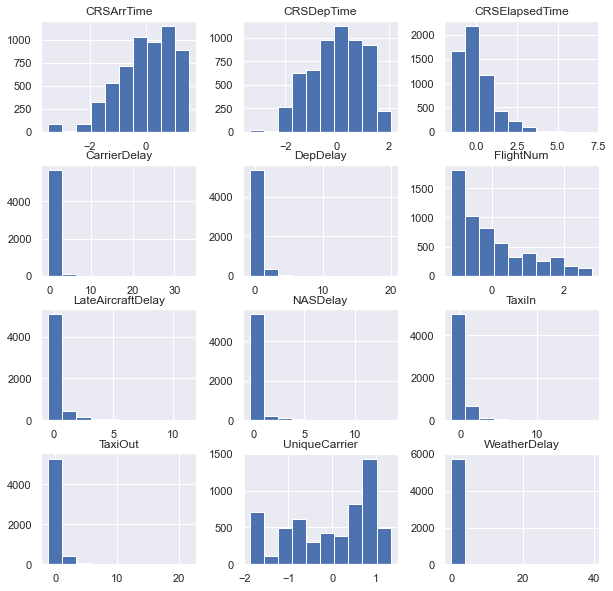

In [13]:
# Distributions of the scaled attributes
# ====================================================
X_scaled.hist(figsize=(10,10))
plt.show()

## **Dimensional Reduction with PCA**

In [14]:
# Appliing PC to the dataset
# ================================================================

pca = PCA(random_state=42)
pca.fit(X_scaled)
print(pca.singular_values_)

[108.18961055  99.56173125  95.97669513  87.5053329   77.60047536
  76.33343608  74.91937251  66.68515684  62.46159804  57.37892971
  41.41837848  10.77199625]


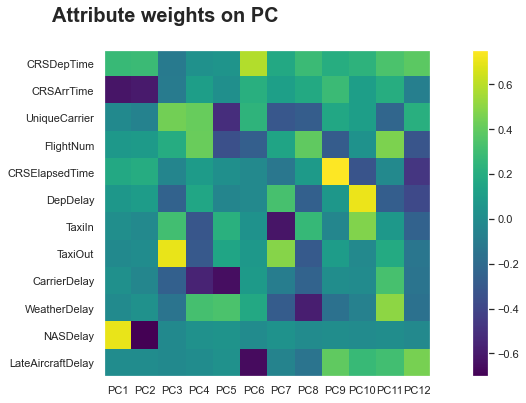

In [15]:
# Heatmap for checkign the weight oh the attributes on each PC
# ===================================================================

data = pca.components_
columns = X_scaled.columns

index = []
x=0
for i in data:
    index.append(f"PC{1+x}")
    x+=1

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
plt.imshow(data, cmap='viridis') # Plotegem la matriu de correlació transposada ".T"
plt.yticks(range(len(columns)), columns)
plt.xticks(range(len(index)), index)
plt.grid(False)
fig.suptitle('Attribute weights on PC', fontsize = 20, fontweight = "bold")
plt.colorbar()


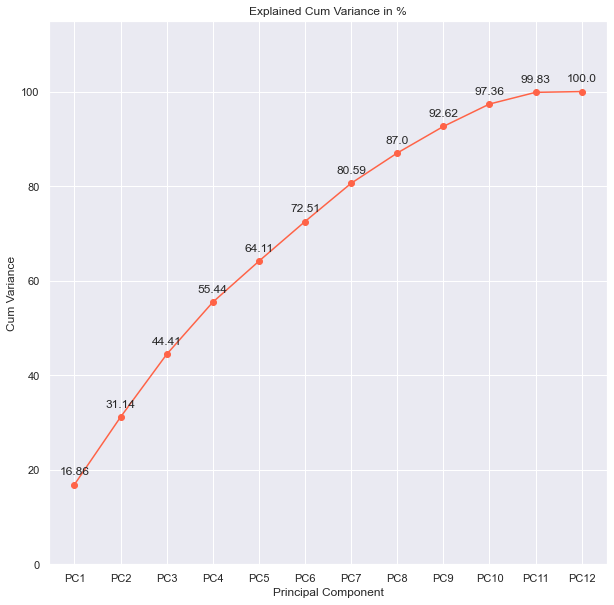

In [16]:
# Ploting the cumulate variance for each PC
# =================================================================

cum_var  = pca.explained_variance_ratio_.cumsum()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
ax.plot(index, cum_var*100, marker = 'o', color='tomato')

for z,h in zip(index, cum_var*100):
    label = round(h, 2)
    ax.annotate(
        label,
        (z,h),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )
    
ax.set_ylim(0, 115)
ax.set_xticks(np.arange(pca.n_components_))
ax.set_title('Explained Cum Variance in %',)
ax.set_xlabel('Principal Component')
ax.set_ylabel('Cum Variance');



In [17]:
# Aplliing the PCA with 9 PCs
# ===============================================================================
pca = PCA(9, random_state=42)
X_pca = pd.DataFrame(pca.fit_transform(X_scaled))

In [18]:
# Splitting the reducted data into train/test
# ============================================================================
X_train, X_test, y_train, y_test = ms.train_test_split(X_pca, y, test_size = 0.25, random_state=42)

## **Generating the models**

In [19]:
# Dummy Classifier
# ============================================================================
dummy_clf = dummy.DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train, y_train)

# Logistic Regression
# ============================================================================
logreg_pca = lm.LogisticRegression(penalty='l2', fit_intercept=False, class_weight=None, random_state=42)
logreg_pca.fit(X_train, y_train)

# K Neigbors 
# ============================================================================
kn_class_pca = KNeighborsClassifier(weights='distance', n_neighbors=8, algorithm='ball_tree', n_jobs=3)
kn_class_pca.fit(X_train, y_train)

# Support Vector Machines 
# ============================================================================
svm_class_pca = svm.LinearSVC(penalty='l2', max_iter=2500, fit_intercept=False, class_weight='balanced', random_state=42)
svm_class_pca.fit(X_train, y_train)

LinearSVC(class_weight='balanced', fit_intercept=False, max_iter=2500,
          random_state=42)

## **Predicting the values and obtaining metrics**

In [20]:
models = [dummy_clf, logreg_pca, kn_class_pca, svm_class_pca]
model_names = ['Dummy', 'Log Reg', 'KN Class', 'SVM Class']

scores_dict={}
for model, name in zip(models, model_names):
    scores = {'Precision':metrics.precision_score(y_test, model.predict(X_test)),
            'Recall':metrics.recall_score(y_test,model.predict(X_test)),
            'Accuracy':metrics.accuracy_score(y_test, model.predict(X_test)),
            'B-Accuracy':metrics.balanced_accuracy_score(y_test, model.predict(X_test)),
            'F1 Score':metrics.f1_score(y_test, model.predict(X_test)),
            'Roc_AUC':metrics.roc_auc_score(y_test, model.predict(X_test)),
            'Confusion Matrix':metrics.confusion_matrix(y_test, model.predict(X_test))}
    scores_dict[name] = scores
    

scores_pca_df = pd.DataFrame.from_dict(scores_dict).transpose()
scores_pca_df


,Precision,Recall,Accuracy,B-Accuracy,F1 Score,Roc_AUC,Confusion Matrix
Dummy,0.72,1.00,0.72,0.50,0.84,0.50,"[[0, 399], [0, 1048]]"
Log Reg,1.00,0.50,0.64,0.75,0.67,0.75,"[[399, 0], [523, 525]]"
KN Class,0.95,0.88,0.88,0.88,0.91,0.88,"[[347, 52], [123, 925]]"
SVM Class,1.00,0.47,0.62,0.74,0.64,0.74,"[[399, 0], [553, 495]]"


[]

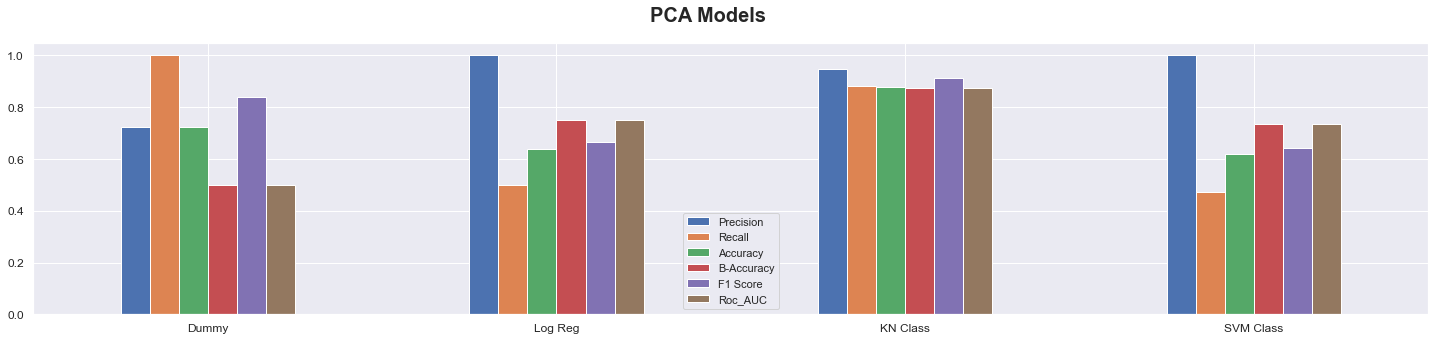

In [21]:
fig, ax = plt.subplots()
scores_pca_df.plot(kind='bar', subplots=False, layout=(1,6), figsize=(25,5), rot=0, fontsize=12, ax=ax)
fig.suptitle('PCA Models', fontsize=20, weight='bold')
plt.plot()

Text(0.5, 0.98, 'PCA ROC Curves')

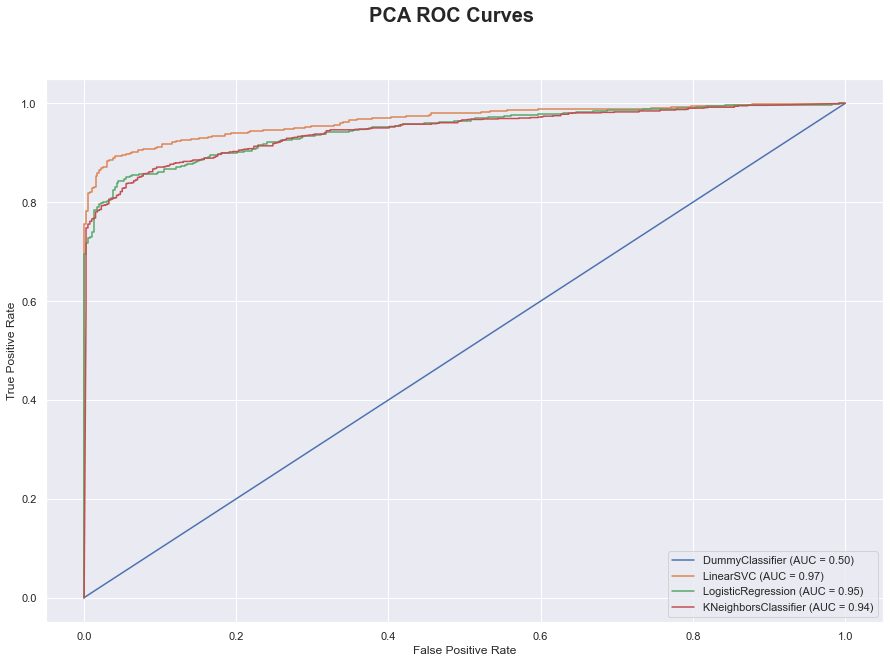

In [22]:
fig, ax = plt.subplots(figsize=(15,10))
roc_dummy = metrics.plot_roc_curve(dummy_clf, X_test, y_test, ax=ax)
roc_svm = metrics.plot_roc_curve(svm_class_pca, X_test, y_test, ax=ax)
roc_logreg = metrics.plot_roc_curve(logreg_pca, X_test, y_test, ax=ax)
roc_kn = metrics.plot_roc_curve(kn_class_pca, X_test, y_test, ax=ax)
fig.suptitle('PCA ROC Curves', fontsize = 20, fontweight = "bold", ha='center')

## **Nivell 3**


- ### **Exercici 6**

No utilitzis la variable DepDelay a l’hora de fer prediccions

## **Selecting the dataframe and dropping the Dep Delay Attribute and spliting in Train/Test**  

In this case will be used the scaled dataframe but with no PCA applied

In [23]:
X_no_dep = X_scaled.drop('DepDelay', axis=1)
X_no_dep

,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,CRSElapsedTime,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,LateAircraftDelay
1251307,-0.83,-0.89,1.00,-0.55,-1.06,-0.38,-0.80,-0.36,-0.12,-0.36,-0.46
4750566,-0.80,-0.24,-1.71,-0.24,0.51,0.02,0.35,0.33,-0.12,0.11,-0.46
6773048,-0.61,-0.59,-0.69,1.81,-0.42,0.02,-0.37,-0.36,-0.12,-0.36,-0.46
58354,1.12,0.88,1.00,-0.46,-0.28,-0.58,0.49,-0.14,-0.12,0.26,0.88
6648930,0.56,0.65,0.49,2.10,-0.66,-0.78,-0.37,-0.36,-0.12,-0.36,0.88
...,...,...,...,...,...,...,...,...,...,...,...
6720291,-1.33,-0.88,0.83,-0.16,0.08,-0.38,-0.01,-0.36,-0.12,-0.36,-0.46
2348405,0.60,1.24,-1.03,-0.53,1.30,0.82,1.21,-0.36,-0.12,0.22,-0.46
1468317,1.26,1.07,0.83,-0.12,-0.73,-0.38,-0.66,-0.36,-0.12,-0.36,-0.46
6875026,-1.80,-1.44,-1.88,0.02,0.58,-0.58,-0.30,-0.36,-0.12,-0.36,-0.46


In [24]:
# Dividing the DF in Train/Test
# =============================================
X_train, X_test, y_train, y_test = ms.train_test_split(X_no_dep, y, test_size = 0.25, random_state=42)
print(f"Train X:{X_train.shape}, Train y:{y_train.shape}\nTest X:{X_test.shape}, {y_test.shape}")

Train X:(4338, 11), Train y:(4338,)
Test X:(1447, 11), (1447,)


## **Setting the new models with the optimized parameters**

In [25]:
# Logistic Regression
# ============================================================================
logreg_nd = lm.LogisticRegression(penalty='l2', fit_intercept=False, class_weight=None, random_state=42)
logreg_nd.fit(X_train, y_train)

# K Neigbors 
# ============================================================================
kn_class_nd = KNeighborsClassifier(weights='distance', n_neighbors=8, algorithm='ball_tree', n_jobs=3)
kn_class_nd.fit(X_train, y_train)

# Support Vector Machines 
# ============================================================================
svm_class_nd = svm.LinearSVC(penalty='l2', max_iter=2500, fit_intercept=False, class_weight='balanced', random_state=42)
svm_class_nd.fit(X_train, y_train)

LinearSVC(class_weight='balanced', fit_intercept=False, max_iter=2500,
          random_state=42)

## **Predicting the values and obtaining metrics**

In [26]:
models = [dummy_clf, logreg_nd, kn_class_nd, svm_class_nd]
model_names = ['Dummy', 'Log Reg', 'KN Class', 'SVM Class']

scores_dict={}
for model, name in zip(models, model_names):
    scores = {'Precision':metrics.precision_score(y_test, model.predict(X_test)),
            'Recall':metrics.recall_score(y_test,model.predict(X_test)),
            'Accuracy':metrics.accuracy_score(y_test, model.predict(X_test)),
            'B-Accuracy':metrics.balanced_accuracy_score(y_test, model.predict(X_test)),
            'F1 Score':metrics.f1_score(y_test, model.predict(X_test)),
            'Roc_AUC':metrics.roc_auc_score(y_test, model.predict(X_test)),
            'Confusion Matrix':metrics.confusion_matrix(y_test, model.predict(X_test))}
    scores_dict[name] = scores
    

scores_nd_df = pd.DataFrame.from_dict(scores_dict).transpose()
scores_nd_df

,Precision,Recall,Accuracy,B-Accuracy,F1 Score,Roc_AUC,Confusion Matrix
Dummy,0.72,1.00,0.72,0.50,0.84,0.50,"[[0, 399], [0, 1048]]"
Log Reg,1.00,0.52,0.65,0.76,0.69,0.76,"[[399, 0], [500, 548]]"
KN Class,0.94,0.86,0.86,0.86,0.90,0.86,"[[343, 56], [147, 901]]"
SVM Class,1.00,0.51,0.64,0.75,0.67,0.75,"[[399, 0], [515, 533]]"


[]

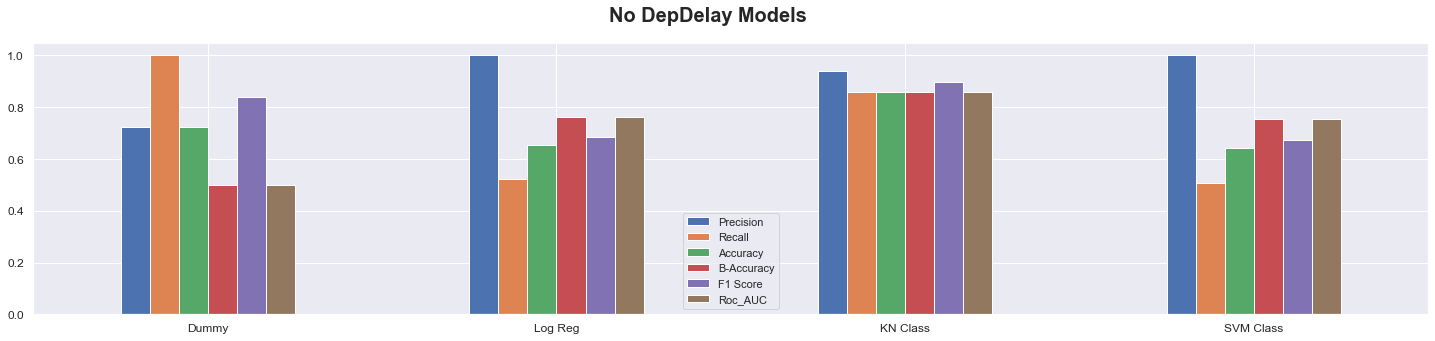

In [27]:
fig, ax = plt.subplots()
scores_nd_df.plot(kind='bar', subplots=False, layout=(1,6), figsize=(25,5), rot=0, fontsize=12, ax=ax)
fig.suptitle('No DepDelay Models', fontsize=20, weight='bold')
plt.plot()

Text(0.5, 0.98, 'No Dep Delay ROC Curves')

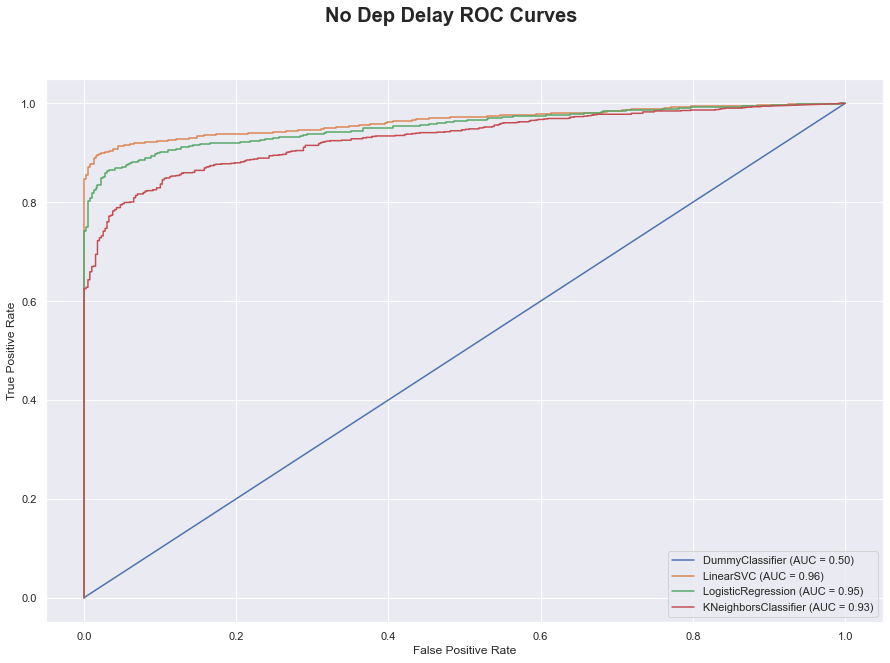

In [28]:
fig, ax = plt.subplots(figsize=(15,10))
roc_dummy = metrics.plot_roc_curve(dummy_clf, X_test, y_test, ax=ax)
roc_svm = metrics.plot_roc_curve(svm_class_nd, X_test, y_test, ax=ax)
roc_logreg = metrics.plot_roc_curve(logreg_nd, X_test, y_test, ax=ax)
roc_kn = metrics.plot_roc_curve(kn_class_nd, X_test, y_test, ax=ax)
fig.suptitle('No Dep Delay ROC Curves', fontsize = 20, fontweight = "bold", ha='center')

## **Comparing PCA and No delay Metrics**

In [29]:
resume = pd.concat([scores_pca_df, scores_nd_df], axis=0, keys=['PCA', 'NO DPT Delay']).reorder_levels(order=[1,0])
resume.sort_index()

Precision Recall Accuracy B-Accuracy F1 Score Roc_AUC  \
Dummy     NO DPT Delay      0.72   1.00     0.72       0.50     0.84    0.50   
          PCA               0.72   1.00     0.72       0.50     0.84    0.50   
KN Class  NO DPT Delay      0.94   0.86     0.86       0.86     0.90    0.86   
          PCA               0.95   0.88     0.88       0.88     0.91    0.88   
Log Reg   NO DPT Delay      1.00   0.52     0.65       0.76     0.69    0.76   
          PCA               1.00   0.50     0.64       0.75     0.67    0.75   
SVM Class NO DPT Delay      1.00   0.51     0.64       0.75     0.67    0.75   
          PCA               1.00   0.47     0.62       0.74     0.64    0.74   

                               Confusion Matrix  
Dummy     NO DPT Delay    [[0, 399], [0, 1048]]  
          PCA             [[0, 399], [0, 1048]]  
KN Class  NO DPT Delay  [[343, 56], [147, 901]]  
          PCA           [[347, 52], [123, 925]]  
Log Reg   NO DPT Delay   [[399, 0], [500, 548]]  
          PCA            [[399, 0], [523, 525]]  
SVM Class NO DPT Delay   [[399, 0], [515, 533]]  
          PCA            [[399, 0], [553, 495]]

array([[<AxesSubplot:title={'center':'(Dummy, NO DPT Delay)'}>,
        <AxesSubplot:title={'center':'(Dummy, PCA)'}>,
        <AxesSubplot:title={'center':'(KN Class, NO DPT Delay)'}>,
        <AxesSubplot:title={'center':'(KN Class, PCA)'}>],
       [<AxesSubplot:title={'center':'(Log Reg, NO DPT Delay)'}>,
        <AxesSubplot:title={'center':'(Log Reg, PCA)'}>,
        <AxesSubplot:title={'center':'(SVM Class, NO DPT Delay)'}>,
        <AxesSubplot:title={'center':'(SVM Class, PCA)'}>]], dtype=object)

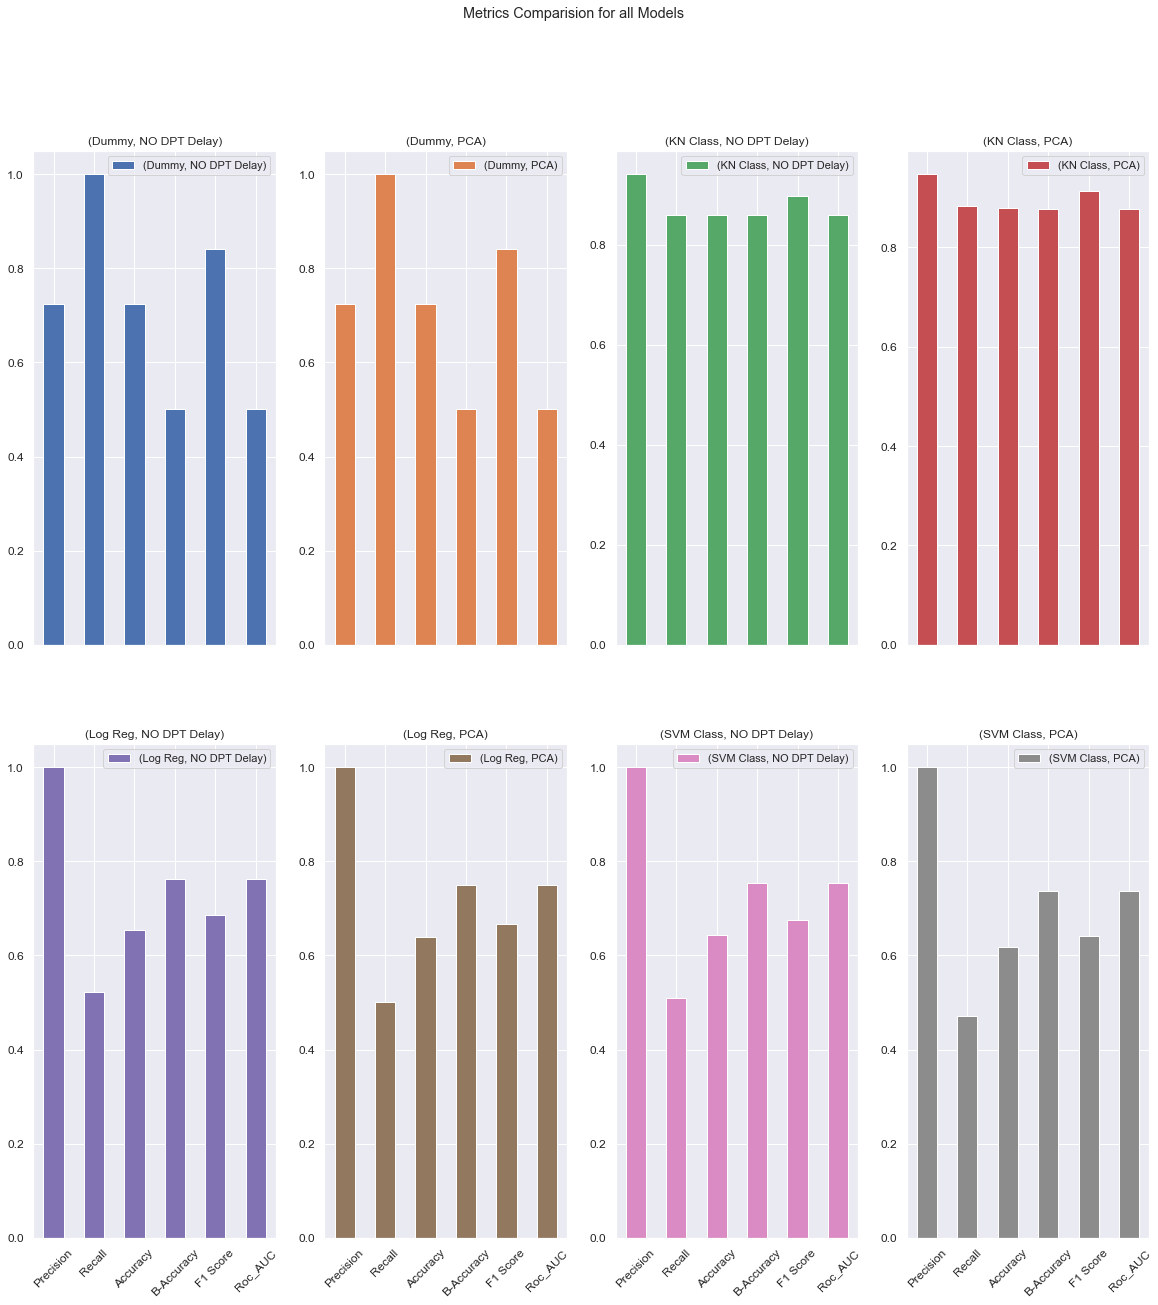

In [30]:
resume_t = resume.drop('Confusion Matrix', axis=1).transpose()
resume_t = resume_t.sort_index(1, level=0, sort_remaining=True)
resume_t

resume_t.plot(kind='bar', figsize=(20,20), subplots=True, layout=(2,4), rot=45, fontsize=12, title='Metrics Comparision for all Models')


For KN Class There PCA has better cores. For Log Reg adn SVM, the moel without the Dep Delay attribute performs slighly better. 
Anyway, in both bases the metrics are similar. 